This code works to 1. create a heatmap that shows the probability of beaching. High value areas represent high likelyhood of a drifter beaching if it were to 'start' there. 2. create a heatmap that shows the average time to beaching by 'start' location

In [2]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters')
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [63]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Point

In [3]:
# loading files
metadata = pd.read_csv('drifter data/global drifter program/csv files/GDP_metadata.csv')
runD = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_drouged.csv')
runUnD = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_undrouged.csv')
nRunD = pd.read_csv('GDP_NonRunAground_drouged-004.csv')
nRunUnD = pd.read_csv('GDP_NonRunAground_undrouged-006.csv')

In [246]:
# explore file shapes
print('runD: ' + str(np.shape(runD))) # run aground drogued 
print('runUnD: ' + str(np.shape(runUnD))) # run aground undrogued
print('nRunD: ' + str(np.shape(nRunD))) # not run aground drogued
print('nRunUnD: ' + str(np.shape(nRunUnD))) # not run aground undrogued
print('metadata: ' + str(np.shape(metadata))) # metadata

runD: (14265865, 6)
runUnD: (23068321, 6)
nRunD: (51183961, 6)
nRunUnD: (77236186, 6)
metadata: (17324, 3)


Death types in metadata: <br>
0 still alive <br>
1 ran aground <br>
2 picked up by vessel<br>
3 stop transmitting<br>
4 sporadic trasmissions<br>
5 bad batteries<br>
6 inactive status<br>

In [341]:
for i in list(metadata['type_death'].unique()):
    print(str(i) + ': ' + str(len(metadata.loc[metadata['type_death']==i])))

3: 10931
1: 4393
2: 1183
6: 25
4: 4
0: 784
5: 4


In [340]:
# read metadata

metadata.head()

,ID,type_death,drogue_lost_date
0,101143,3,1.333325e+09
1,101144,3,1.334448e+09
2,101509,1,1.331078e+09
3,101510,1,1.328141e+09
4,101511,3,1.355098e+09


In [343]:
# drops all but the starting location
RunD_starts = runD.drop_duplicates(subset='ID', keep='first') 
nRunD_starts = nRunD.drop_duplicates(subset='ID', keep='first')
runUnD_starts = runUnD.drop_duplicates(subset='ID', keep='first')
nRunUnD_starts = nRunUnD.drop_duplicates(subset='ID', keep='first')

# drops all but the final location
RunD_last = runD.drop_duplicates(subset='ID', keep='last') 
nRunD_last = nRunD.drop_duplicates(subset='ID', keep='last')
runUnD_last = runUnD.drop_duplicates(subset='ID', keep='last')
nRunUnD_last = nRunUnD.drop_duplicates(subset='ID', keep='last')


KeyboardInterrupt: 

In [372]:
# get lats and lons separated and assigns value 1 to all that run aground and 0 to those that do not
RunD_lats = np.array(RunD_starts['lat'])#.tolist()
RunD_longs = np.array(RunD_starts['lon'])#.tolist()
RunD_values = np.ones(len(RunD_starts))

nRunD_lats = np.array(nRunD_starts['lat'])#.tolist()
nRunD_longs = np.array(nRunD_starts['lon'])#.tolist()
nRunD_values = np.zeros(len(nRunD_starts))

runUnD_lats = np.array(runUnD_starts['lat'])
runUnD_longs = np.array(runUnD_starts['lon'])
runUnD_values = np.ones(len(runUnD_starts))

nRunUnD_lats = np.array(nRunUnD_starts['lat'])
nRunUnD_longs = np.array(nRunUnD_starts['lon'])
nRunUnD_values = np.zeros(len(nRunUnD_starts))
# bootstrap the data to reduce size
#RunD_lats_boot = np.random.choice(RunD_lats, size=100, replace=False)
#nRunD_starts_boot = np.random.choice(nRunD_starts, size=100000, replace=False)

In [263]:
lats = np.concatenate((RunD_lats, runUnD_lats, nRunD_lats, nRunUnD_lats))
longs = np.concatenate((RunD_longs, runUnD_longs, nRunD_longs, nRunUnD_longs))
values = np.concatenate((RunD_values, runUnD_values, nRunD_values, nRunUnD_values))

In [264]:
# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

valid_lats = []
valid_lons = []
valid_values = []

for lat, lon, value in zip(lats, longs, values):
    # Create a Point geometry for each latitude and longitude
    point = Point(lon, lat)
    
    # Check if the point is over land (coastlines)
    if not any(world['geometry'].intersects(point)):
        valid_lats.append(lat)
        valid_lons.append(lon)
        valid_values.append(value)

In [319]:
# Define the grid for the heatmap
n_lons, n_lats = 720, 360 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])

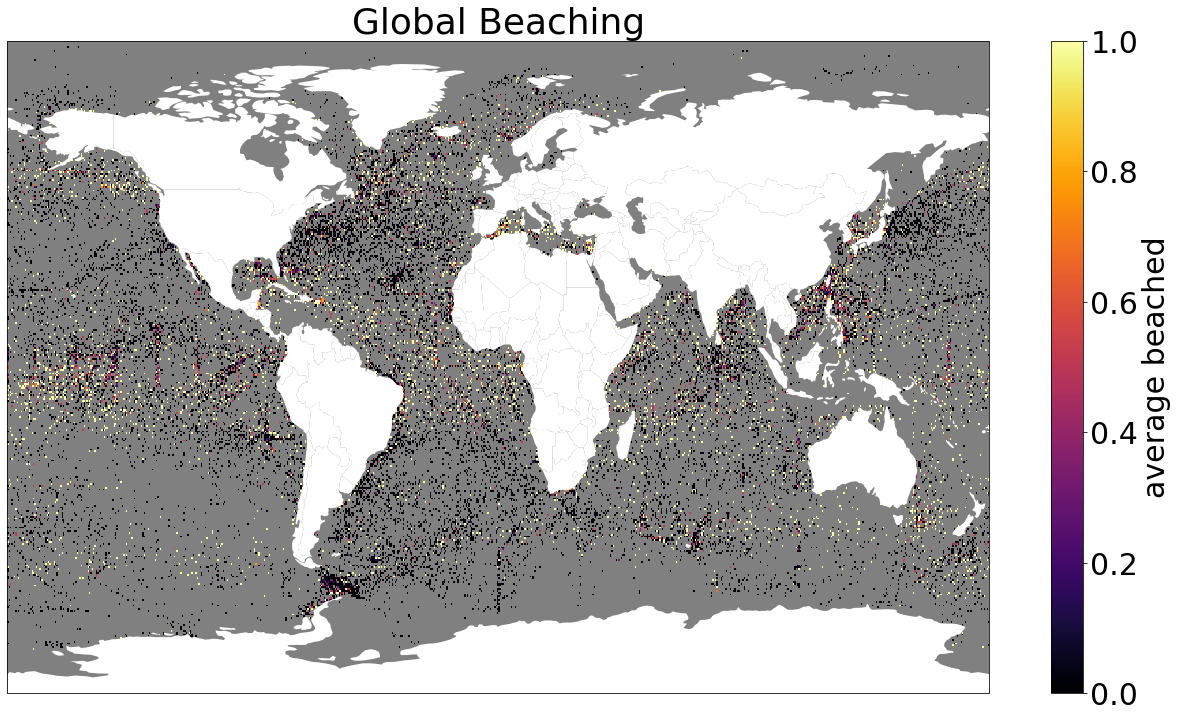

In [328]:
fig = plt.figure(figsize=(22, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.get_cmap('inferno')
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
# Plot the land polygons with white facecolor, no edges
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')
plt.colorbar(mesh, label='average beached')
ax.set_aspect('auto')
plt.title('Global Beaching')

plt.show()

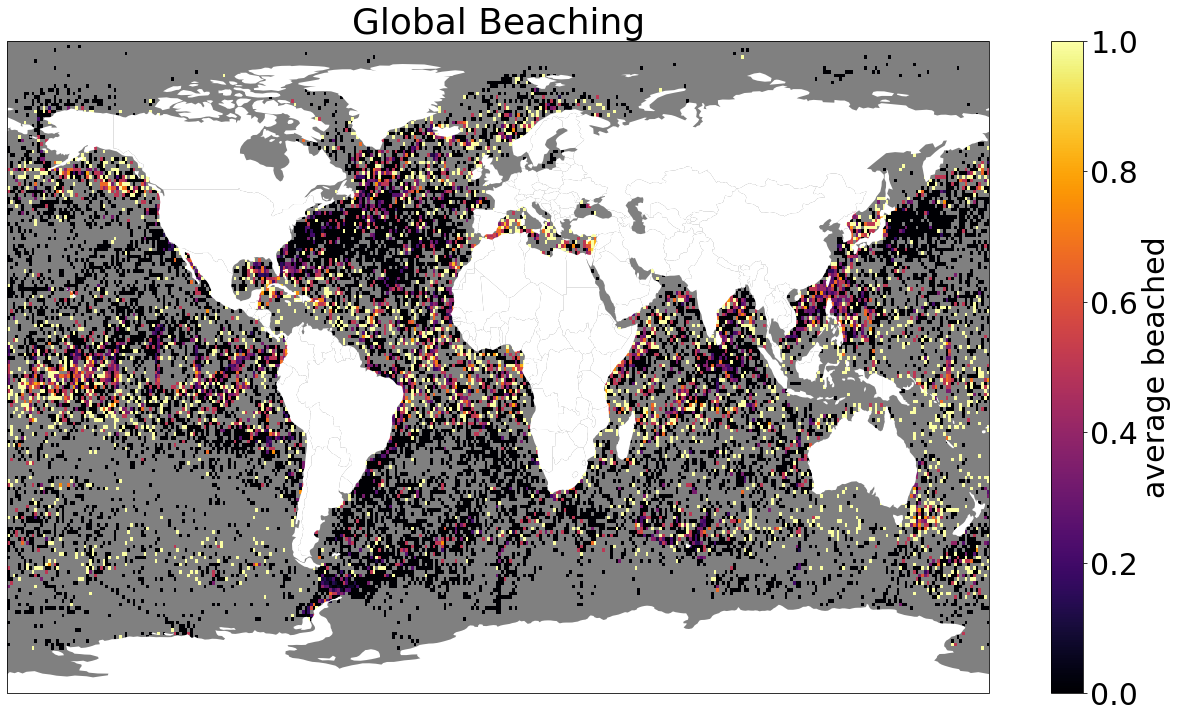

In [329]:
# Define the grid for the heatmap
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])
fig = plt.figure(figsize=(22, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.get_cmap('inferno')
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
# Plot the land polygons with white facecolor, no edges
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')
plt.colorbar(mesh, label='average beached')
ax.set_aspect('auto')
plt.title('Global Beaching')

plt.show()


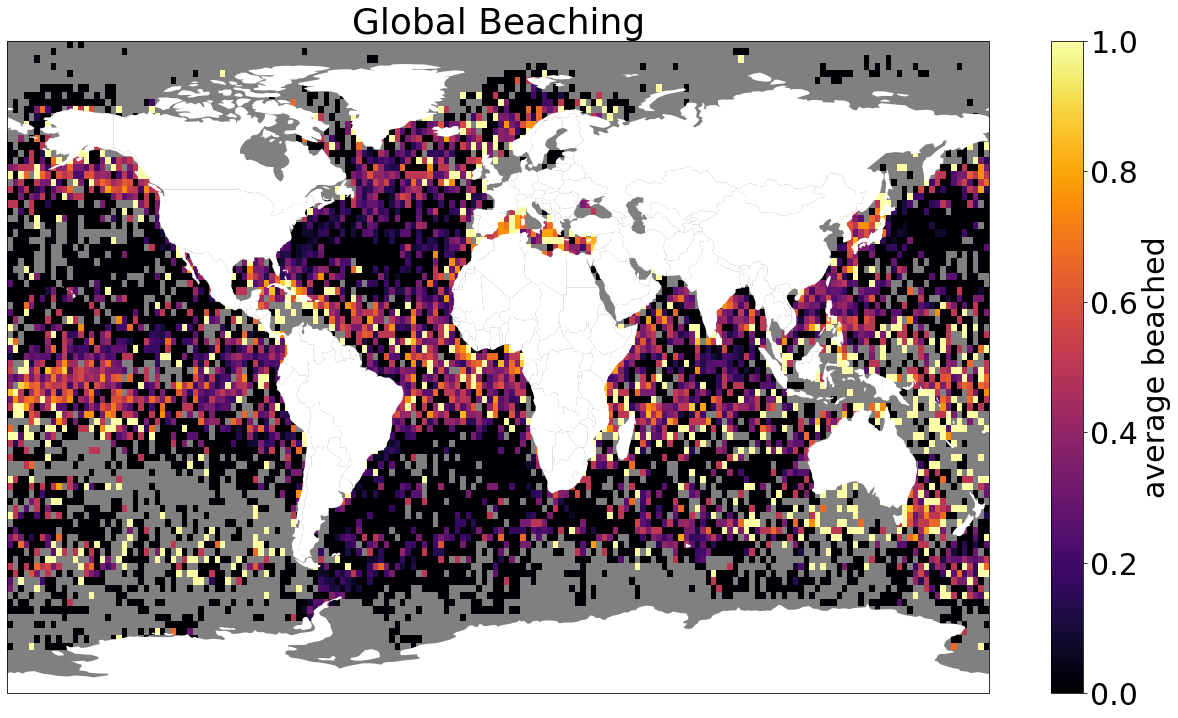

In [330]:
# Define the grid for the heatmap
n_lons, n_lats = 180, 90 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])
fig = plt.figure(figsize=(22, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.get_cmap('inferno')
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
# Plot the land polygons with white facecolor, no edges
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')
plt.colorbar(mesh, label='average beached')
ax.set_aspect('auto')
plt.title('Global Beaching')

plt.show()


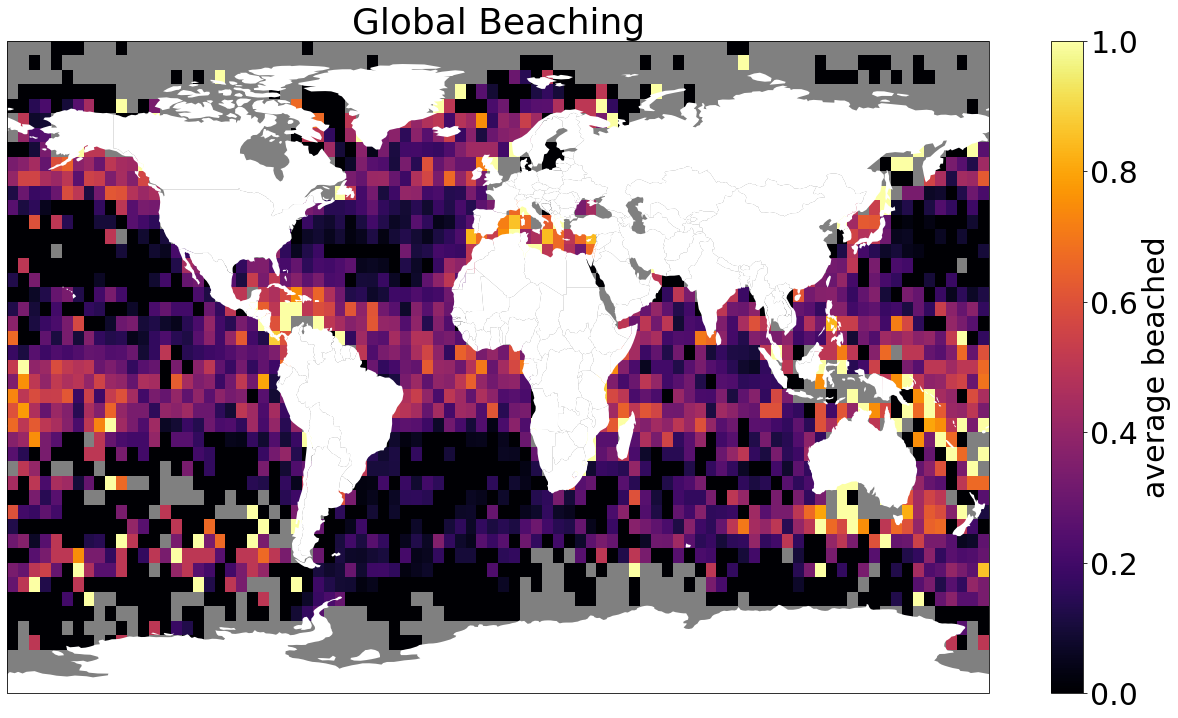

In [331]:
# Define the grid for the heatmap
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])
fig = plt.figure(figsize=(22, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.get_cmap('inferno')
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
# Plot the land polygons with white facecolor, no edges
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')
plt.colorbar(mesh, label='average beached')
ax.set_aspect('auto')
plt.title('Global Beaching')

plt.show()


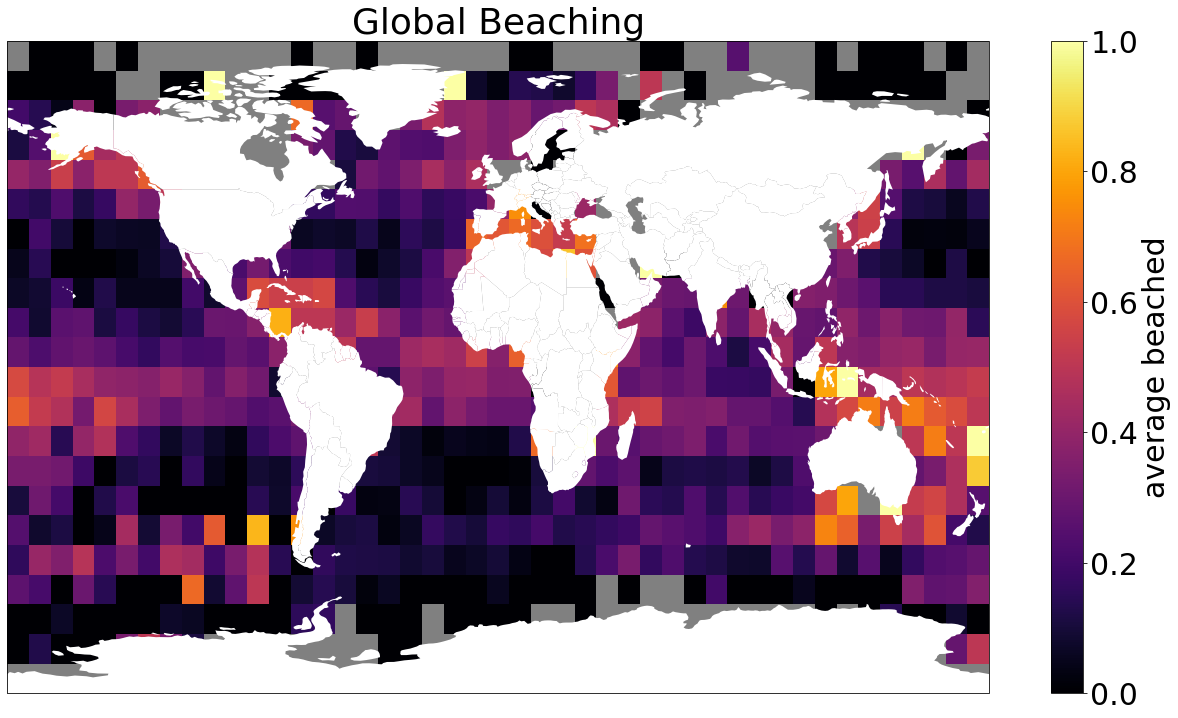

In [332]:
# Define the grid for the heatmap
n_lons, n_lats = 45, 22 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])
fig = plt.figure(figsize=(22, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.get_cmap('inferno')
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
# Plot the land polygons with white facecolor, no edges
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')
plt.colorbar(mesh, label='average beached')
ax.set_aspect('auto')
plt.title('Global Beaching')

plt.show()

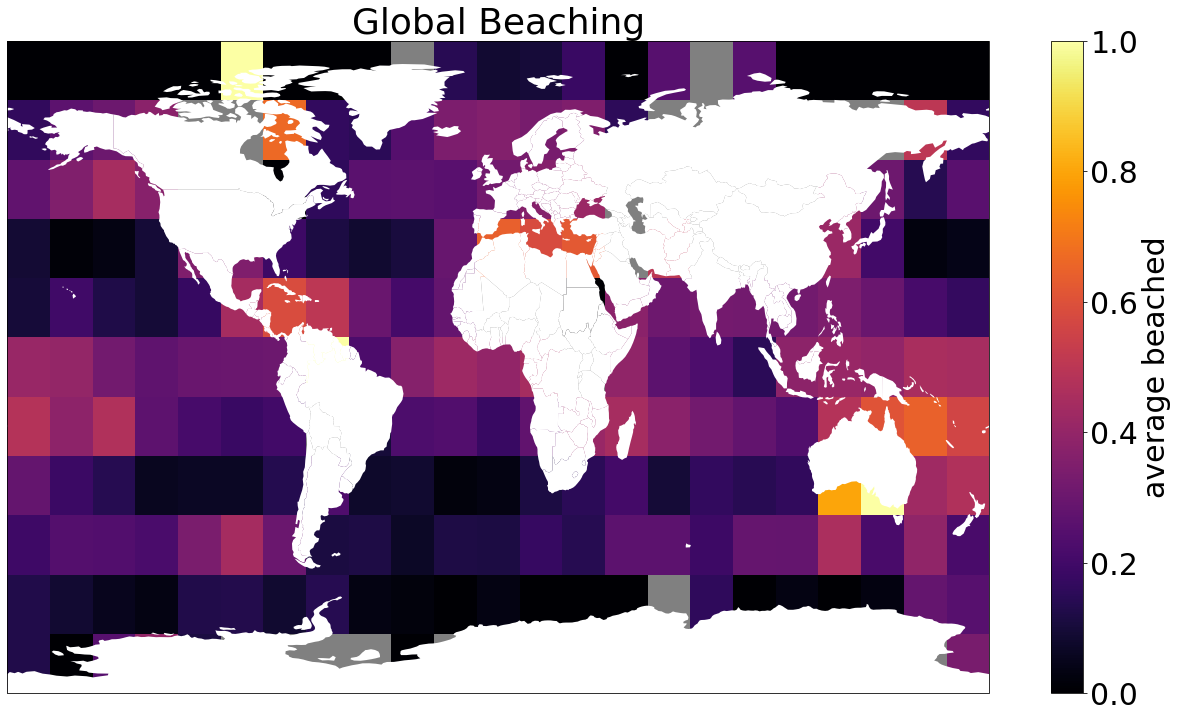

In [333]:
# Define the grid for the heatmap
n_lons, n_lats = 23, 11 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])
fig = plt.figure(figsize=(22, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.get_cmap('inferno')
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
# Plot the land polygons with white facecolor, no edges
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')
plt.colorbar(mesh, label='average beached')
ax.set_aspect('auto')
plt.title('Global Beaching')

plt.show()

# Time to Beaching

In [393]:
# calculate length of time to beaching
time_to_beach_RunD = []
for i in range(len(RunD_last)):
    time_to_beach_RunD.append(RunD_last.iloc[i,5] - RunD_starts.iloc[i, 5])
time_to_beach_runUnD = []
for i in range(len(runUnD_last)):
    time_to_beach_runUnD.append(runUnD_last.iloc[i,5] - runUnD_starts.iloc[i, 5])
#time_to_beach = np.concatenate((time_to_beach_RunD,time_to_beach_runUnD))

In [399]:
# normalize
min_value = min(time_to_beach_RunD)
max_value = max(time_to_beach_RunD)

# Perform Min-Max scaling
time_to_beach__RunD_normalized = [(x - min_value) / (max_value - min_value) for x in time_to_beach_RunD]

# normalize
min_value = min(time_to_beach_runUnD)
max_value = max(time_to_beach_runUnD)

# Perform Min-Max scaling
time_to_beach__runUnD_normalized = [(x - min_value) / (max_value - min_value) for x in time_to_beach_runUnD]

(array([5.860e+03, 1.515e+03, 5.940e+02, 2.630e+02, 1.150e+02, 4.900e+01,
        1.900e+01, 1.000e+01, 5.000e+00, 4.000e+00]),
 array([0.0000000e+00, 1.8332640e+07, 3.6665280e+07, 5.4997920e+07,
        7.3330560e+07, 9.1663200e+07, 1.0999584e+08, 1.2832848e+08,
        1.4666112e+08, 1.6499376e+08, 1.8332640e+08]),
 <BarContainer object of 10 artists>)

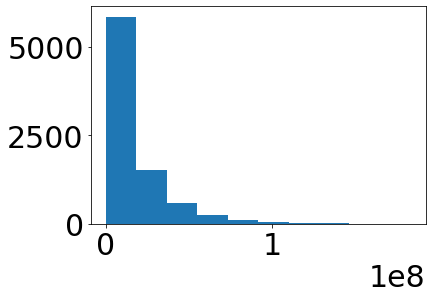

In [392]:
plt.hist(time_to_beach)

In [400]:
# get lats and lons separated and assigns value 1 to all that run aground and 0 to those that do not
RunD_lats = np.array(RunD_starts['lat'])#.tolist()
RunD_longs = np.array(RunD_starts['lon'])#.tolist()
RunD_values = time_to_beach__RunD_normalized # TIME

nRunD_lats = np.array(nRunD_starts['lat'])#.tolist()
nRunD_longs = np.array(nRunD_starts['lon'])#.tolist()
nRunD_values = np.ones(len(nRunD_starts))

runUnD_lats = np.array(runUnD_starts['lat'])
runUnD_longs = np.array(runUnD_starts['lon'])
runUnD_values = time_to_beach__runUnD_normalized # TIME

nRunUnD_lats = np.array(nRunUnD_starts['lat'])
nRunUnD_longs = np.array(nRunUnD_starts['lon'])
nRunUnD_values = np.ones(len(nRunUnD_starts))

In [401]:
lats = np.concatenate((RunD_lats, runUnD_lats, nRunD_lats, nRunUnD_lats))
longs = np.concatenate((RunD_longs, runUnD_longs, nRunD_longs, nRunUnD_longs))
values = np.concatenate((RunD_values, runUnD_values, nRunD_values, nRunUnD_values))

In [402]:
# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

valid_lats = []
valid_lons = []
valid_values = []

for lat, lon, value in zip(lats, longs, values):
    # Create a Point geometry for each latitude and longitude
    point = Point(lon, lat)
    
    # Check if the point is over land (coastlines)
    if not any(world['geometry'].intersects(point)):
        valid_lats.append(lat)
        valid_lons.append(lon)
        valid_values.append(value)

In [414]:
# Define the grid for the heatmap
n_lons, n_lats = 180, 90 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])

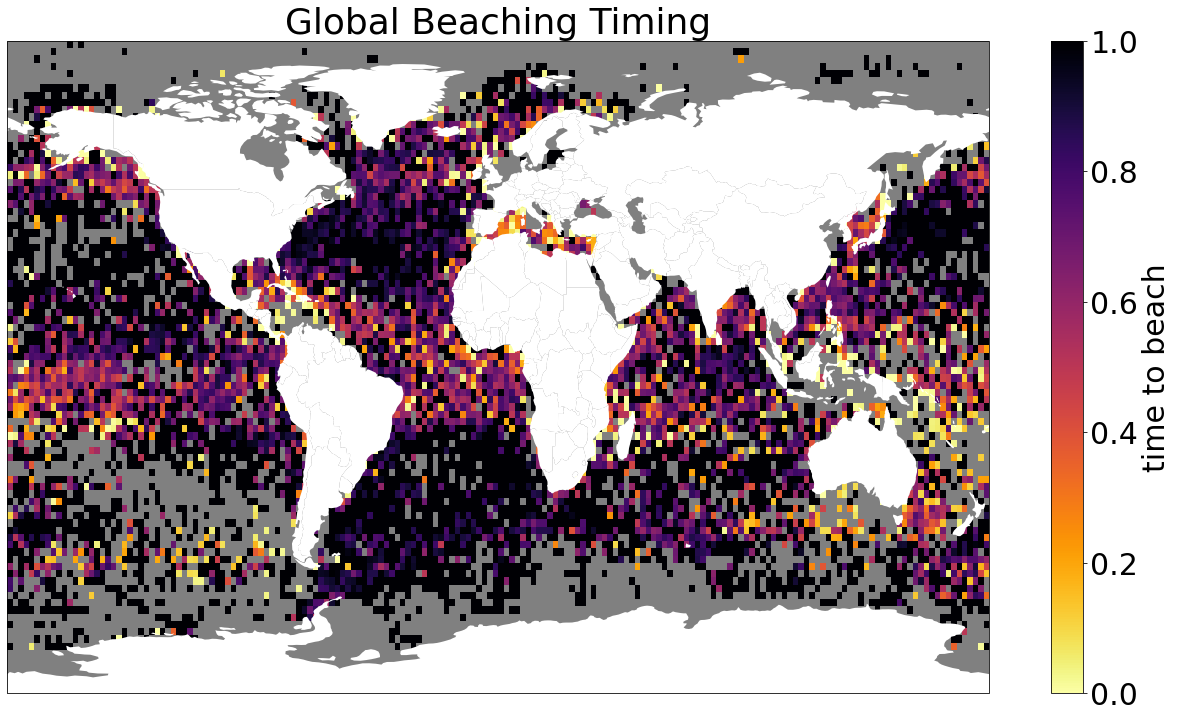

In [415]:

fig = plt.figure(figsize=(22, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
#cmap = plt.get_cmap('inferno')
cmap = plt.cm.get_cmap("inferno").copy()
cmap = cmap.reversed()
cmap.set_bad('grey')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
# Plot the land polygons with white facecolor, no edges
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')
plt.colorbar(mesh, label='time to beach')
ax.set_aspect('auto')
plt.title('Global Beaching Timing')

plt.show()

In [416]:
# Define the grid for the heatmap
n_lons, n_lats = 23, 11 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])


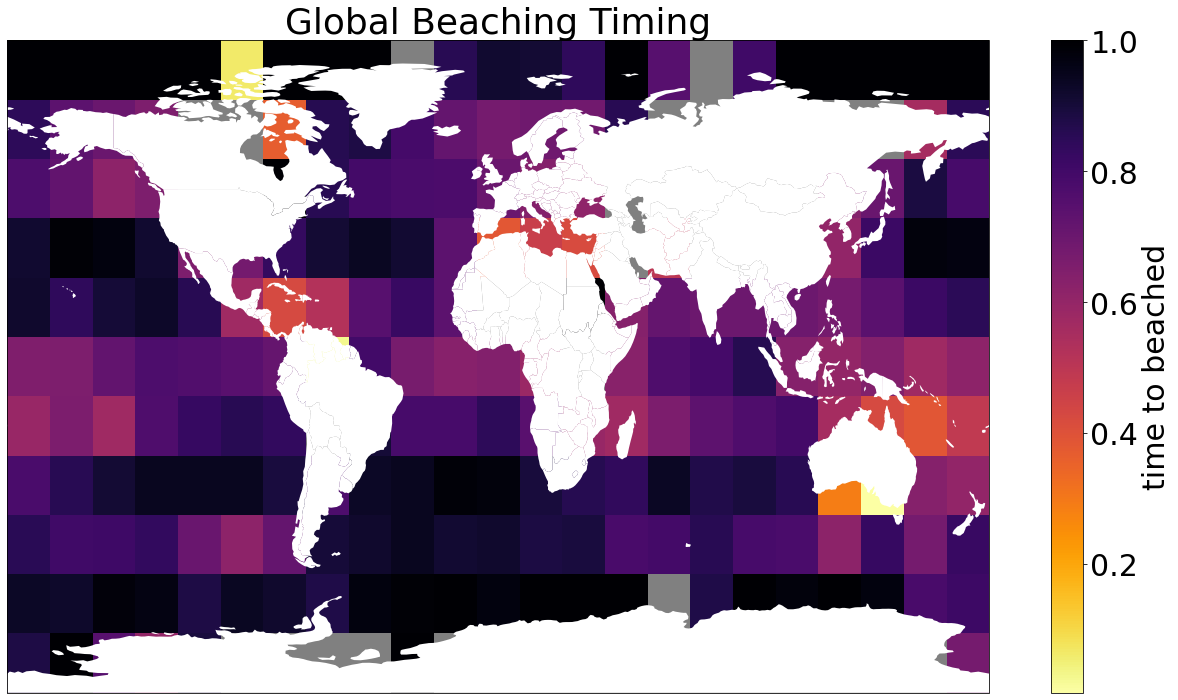

In [417]:
fig = plt.figure(figsize=(22, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

#cmap = plt.get_cmap('inferno')
cmap = plt.cm.get_cmap("inferno").copy()
cmap = cmap.reversed()
cmap.set_bad('grey')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
# Plot the land polygons with white facecolor, no edges
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')
plt.colorbar(mesh, label='time to beached')
ax.set_aspect('auto')
plt.title('Global Beaching Timing')

plt.show()